In [74]:
#Import Libraries
import io
import math 
import os
import pathlib
from glob import glob

import earthpy as et
import earthpy.appeears as etapp
import earthpy.earthexplorer as etee
import geopandas as gpd
import hvplot.xarray
import hvplot.pandas
import matplotlib.pyplot as plt
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
from shapely.geometry import box
from xrspatial import slope

In [53]:
# Create data directory
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final')

if not os.path.exists(data_dir):
        os.makedirs(data_dir)

# Make data directory the working directory
os.chdir(data_dir)

# Check working directory
print(os.getcwd())

# # Create directory for soil datafiles
# soil_path=os.path.join(data_dir, 'soil')
# if not os.path.exists(soil_path):
#         os.makedirs(soil_path)

/home/jovyan/earth-analytics/data/final


In [54]:
# Code adapted from: https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
# Create directory
grassland_url = ('https://data.fs.usda.gov/geodata/edw/'
                 'edw_resources/shp/S_USA.NationalGrassland.zip'
)
print('Downloading shapefile...')

# Request data from url
grassland_request = requests.get(grassland_url)
grassland_zip = zipfile.ZipFile(io.BytesIO(grassland_request.content))
print("Done")

# Extract files from Zip to 
grassland_zip.extractall(
    path=os.path.join(data_dir, 'national-grassland')
    )

Done


In [55]:
# Import shapefile
grassland_gdf = gpd.read_file(os.path.join(
    data_dir, 'national-grassland', 'S_USA.NationalGrassland.shp')
    )

select_grassland_gdf = (
    grassland_gdf
    .set_index('GRASSLANDN')
    .loc[['Comanche National Grassland', 'Pawnee National Grassland']]
)
select_grassland_gdf

,NATIONALGR,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
GRASSLANDN,,,,,
Comanche National Grassland,295522010328,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69224, -104.0225..."
Pawnee National Grassland,295523010328,208424.885,0.089972,15.341594,"MULTIPOLYGON (((-104.58106 40.82664, -104.5810..."


In [56]:
# Download Polaris tif files
# Code adapted from: 
        # https://www.tutorialspoint.com/downloading-files-from-web-using-python
        # https://github.com/njadid/Polaris_Processor/blob/master/download_polaris.py

def download_and_merge_polaris(data_directory, input_gdf):
    """
    This function reads in Polaris soil data for the extent of an input
    geodataframe. Data is stored in a "soil_data" subdirectory within a 
    specified data directory. The soil datafiles are merged and saved
    as "merged_soil_data.tif".

    Attributes
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads. 
    
    input_gdf: gdf
        A geodataframe that defines the boundaries for your area of 
        interest. Polaris soil data will be downloaded according to the
        bounds of this geodataframe.
    
    Returns
    ----------
    merged_da: array
        A data array of the merged soil data for the extent of the 
        input geodaframe. Stored in the "soil_data" sub-directory of
        the input directory.
    """
    # Define extent and round to whole numbers for defining soil path file names
    bounds = (input_gdf.total_bounds)
    # Round minimum bounds down and upper bounds up
    min_lon = math.floor(bounds[0])
    max_lon = math.ceil(bounds[2])
    min_lat = math.floor(bounds[1])
    max_lat = math.ceil(bounds[3])
    # Define range
    lat_range = range(min_lat,max_lat)
    lon_range = range(min_lon,max_lon)
    # Create template for polaris url path
    polaris_template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                   '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
    # Create for file names
    polaris_template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'
    # Create sub-directory for soil data
    soil_dir = os.path.join(data_directory, "soil_data")
    if not os.path.exists(soil_dir):
        os.makedirs(soil_dir)
    # For each latitude and longitude in the extent, download file
    for lat in lat_range:
        for lon in lon_range:
            # Define url for each data file in extent
            url = polaris_template_url.format('ph',
                                      'mean',
                                      '60_100',
                                      str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            # Define file name for each data file in extent
            file_name = polaris_template_name.format(str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            # Check if tif file is in directory. Download if not.
            file_name_path = os.path.join(soil_dir, file_name)
            if not os.path.exists(file_name_path): 
                print(file_name, "does not exist. Downloading file")
                r = requests.get(url, allow_redirects=True)
                open(file_name_path, 'wb').write(r.content)
            else:
                print(file_name, "is already downloaded")
            
    # Merge arrays if the merged file does not exist
    if not os.path.exists(os.path.join(soil_dir, "merged_soil_data.tif")): 
        print("Soil data is being merged.")
        tif_paths = glob(os.path.join(soil_dir, '*.tif'))
        das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
        merged_da = rxrmerge.merge_arrays(das)
        merged_da.rio.to_raster(
            os.path.join(soil_dir, "merged_soil_data.tif")
            )
    else:
        print("A merged soil data array already exists.")
        merged_da = rxr.open_rasterio(
            os.path.join(soil_dir, "merged_soil_data.tif"), masked=True
            )
    return merged_da

merged_soil_da = download_and_merge_polaris(data_dir, select_grassland_gdf)

mean_ph_lat3637_lon-105-104.tif is already downloaded
mean_ph_lat3637_lon-104-103.tif is already downloaded
mean_ph_lat3637_lon-103-102.tif is already downloaded
mean_ph_lat3738_lon-105-104.tif is already downloaded
mean_ph_lat3738_lon-104-103.tif is already downloaded
mean_ph_lat3738_lon-103-102.tif is already downloaded
mean_ph_lat3839_lon-105-104.tif is already downloaded
mean_ph_lat3839_lon-104-103.tif is already downloaded
mean_ph_lat3839_lon-103-102.tif is already downloaded
mean_ph_lat3940_lon-105-104.tif is already downloaded
mean_ph_lat3940_lon-104-103.tif is already downloaded
mean_ph_lat3940_lon-103-102.tif is already downloaded
mean_ph_lat4041_lon-105-104.tif is already downloaded
mean_ph_lat4041_lon-104-103.tif is already downloaded
mean_ph_lat4041_lon-103-102.tif is already downloaded
mean_ph_lat4142_lon-105-104.tif is already downloaded
mean_ph_lat4142_lon-104-103.tif is already downloaded
mean_ph_lat4142_lon-103-102.tif is already downloaded
A merged soil data array alr

# Elevation Data

In [57]:
# select_grassland_gdf

# select_grassland_gdf = select_grassland_gdf.to_crs(4326)

In [58]:
# https://lpdaac.usgs.gov/products/srtmgl1v003/
# https://appeears.earthdatacloud.nasa.gov/api/#temporary-s3-credentials
# https://appeears.earthdatacloud.nasa.gov/products
# https://lpdaac.usgs.gov/resources/e-learning/getting-started-with-the-a%CF%81%CF%81eears-api-submitting-and-downloading-an-area-request/

# Download Elevation Data Using Appeears
elevation_downloader = etapp.AppeearsDownloader(
    download_key="SRTM_DEM",
    ea_dir=data_dir,
    product="SRTMGL1_NC.003",
    layer="SRTMGL1_DEM",
    start_date="02-11",
    end_date="02-21",
    recurring=True,
    year_range=[2000, 2000],
    polygon=select_grassland_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(elevation_downloader.data_dir):
    elevation_downloader.download_files()

In [59]:
# Read elevation data.
elevation_tif_path = (
    os.path.join(data_dir, 'SRTM_DEM',
                'SRTMGL1_NC.003_2000001_to_2023342',
                'SRTMGL1_NC.003_SRTMGL1_DEM_doy2000042_aid0001.tif')
)

# elevation_da = rxr.open_rasterio(elevation_tif_path, masked=True)
# elevation_da

# New version of reading in elevation data array
elev_da = rxr.open_rasterio(elevation_tif_path, masked=True).squeeze()
elev_da.name = 'Elevation'

In [60]:
# elev_da.plot()

In [61]:
# elev_da_proj.plot()

In [62]:
# Calculate slope for area for interest
# Projection based on UTM 13: https://epsg.io/32613
elev_da_proj_da = elev_da.rio.reproject("EPSG:32613")
aoi_slope_da = slope(elev_da_proj_da)
aoi_slope_da

<xarray.DataArray 'slope' (y: 15394, x: 7610)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 5.175e+05 5.176e+05 ... 7.39e+05 7.391e+05
  * y            (y) float64 4.542e+06 4.542e+06 ... 4.094e+06 4.094e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    add_offset:     0.0
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    units:          Meters

In [63]:
# aoi_slope_da.plot(robust=True)

In [64]:
# Clip elevation data to selected grasslands
elev_clip_da = elev_da.rio.clip(select_grassland_gdf.geometry)
# elev_clip_da.plot()

In [65]:
aoi_clip_slope_da = aoi_slope_da.rio.clip(select_grassland_gdf.to_crs("EPSG:32613").geometry)
# aoi_clip_slope_da.plot(robust=True)

# Climate Data

In [87]:
# Define urls for Climate Data
# CCSM4_rcp45_pr_url = (
#     "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
#     "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
# )
# MIROC5_rcp45_pr_url = (
#     "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
#     "agg_macav2metdata_pr_MIROC5_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc"
# )

CCSM4_2050_rcp45_pr_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss/"
    "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
    "?var=precipitation"
    "&disableLLSubset=on"
    "&disableProjSubset=on"
    "&horizStride=1&time_start=2040-01-15T00%3A00%3A00Z"
    "&time_end=2040-12-15T00%3A00%3A00Z"
    "&timeStride=1"
    "&accept=netcdf"
)

maca_response = requests.get(CCSM4_2050_rcp45_pr_url)

with open('maca.nc', 'wb') as maca_file:
    maca_file.write(maca_response.content)

CCSM4_2050_rcp45_pr_da = xr.open_dataset('maca.nc')

# # 
# try:
#     CCSM4_2050_rcp45_pr_da = xr.open_dataset(CCSM4_2050_rcp45_pr_url)
# except OSError as oe:
#     print("The file that you are trying to connect to"
#           "doesn't exist. Check path.")
    
CCSM4_2050_rcp45_pr_da

<xarray.Dataset>
Dimensions:        (time: 12, lat: 585, lon: 1386)
Coordinates:
  * time           (time) object 2040-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lat            (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * lon            (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes: (12/48)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326
    Conventions:                     CF-1.0
    History:                         Translated to CF-1.0 Conventions by Netc...

In [88]:
# select_grassland_gdf.to_crs(CCSM4_rcp45_pr_da.rio.crs).plot()
# maca_crs = CCSM4_2050_rcp45_pr_da.rio.crs
CCSM4_2050_rcp45_pr_da = CCSM4_2050_rcp45_pr_da.assign_coords(lon =  CCSM4_2050_rcp45_pr_da.lon - 360, inplace=True)
precipitation_da = CCSM4_2050_rcp45_pr_da.precipitation
precipitation_da.rio.write_crs("epsg:4326", inplace=True)
precipitation_da.rio.set_spatial_dims('lon','lat',inplace=True)
# CCSM4_2050_rcp45_pr_da = CCSM4_rcp45_pr_da.rio.write_crs(da_crs)

precipitation_da.mean('time').hvplot(rasterize=True) * select_grassland_gdf.hvplot()

BokehModel(combine_events=True, render_bundle={'docs_json': {'1a8bc438-3625-4d00-a8e4-587d4c8afd7d': {'version…

Task exception was never retrieved
future: <Task finished name='Task-85' coro=<Callback.process_on_change() done, defined at /opt/conda/lib/python3.10/site-packages/holoviews/plotting/bokeh/callbacks.py:355> exception=UnsetValueError("figure(id='p5437', ...).inner_height doesn't have a value set")>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/holoviews/plotting/bokeh/callbacks.py", line 374, in process_on_change
    msg[attr] = self.resolve_attr_spec(path, cb_obj)
  File "/opt/conda/lib/python3.10/site-packages/holoviews/plotting/bokeh/callbacks.py", line 281, in resolve_attr_spec
    resolved = getattr(resolved, p, None)
  File "/opt/conda/lib/python3.10/site-packages/bokeh/core/property/descriptors.py", line 283, in __get__
    raise UnsetValueError(f"{obj}.{self.name} doesn't have a value set")
bokeh.core.property.descriptors.UnsetValueError: figure(id='p5437', ...).inner_height doesn't have a value set

During handling of the above exception, a

In [90]:
# Clip to area of interest.
CCSM4_2050_rcp45_pr_clip_da = precipitation_da.rio.clip_box(
    *select_grassland_gdf.total_bounds
)
CCSM4_2050_rcp45_pr_clip_da

<xarray.DataArray 'precipitation' (time: 12, lat: 98, lon: 60)>
array([[[22.552557, 20.03384 , ...,  8.761979,  9.053664],
        [23.685637, 22.792408, ...,  8.381123,  8.975254],
        ...,
        [12.938507, 12.157864, ...,  3.837032,  3.889225],
        [11.565521, 10.911588, ...,  4.140411,  3.820755]],

       [[63.135452, 58.72408 , ..., 51.91762 , 53.76008 ],
        [65.04356 , 67.943085, ..., 52.586956, 54.178978],
        ...,
        [34.60325 , 32.25206 , ..., 36.70725 , 36.060444],
        [33.230484, 31.40286 , ..., 36.30881 , 37.07155 ]],

       ...,

       [[31.19308 , 32.192814, ..., 25.792885, 24.587578],
        [35.25309 , 32.644676, ..., 24.803305, 20.616999],
        ...,
        [32.17422 , 29.272356, ..., 24.22066 , 22.870667],
        [32.594547, 31.238894, ..., 22.445023, 21.955826]],

       [[40.294735, 39.195553, ..., 34.076843, 36.235786],
        [40.6284  , 38.94745 , ..., 35.883995, 36.370293],
        ...,
        [12.812468, 13.780195, ..., 23.70382 , 22.6384  ],
        [14.428091, 14.870716, ..., 25.56631 , 23.64138 ]]], dtype=float32)
Coordinates:
  * time     (time) object 2040-01-15 00:00:00 ... 2040-12-15 00:00:00
  * lat      (lat) float64 36.98 37.02 37.06 37.1 ... 40.9 40.94 40.98 41.02
  * lon      (lon) float64 -104.8 -104.7 -104.7 -104.6 ... -102.4 -102.4 -102.3
    inplace  bool True
    crs      int64 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    grid_mapping:   crs
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

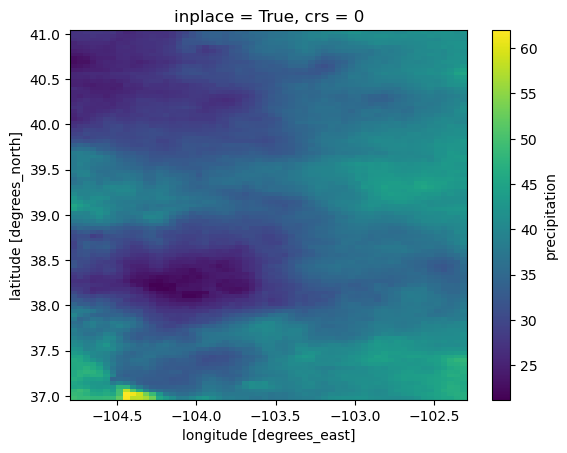

In [92]:
CCSM4_2050_rcp45_pr_clip_da.mean("time").plot.imshow(x='lon', y='lat')

# Check if arrays match

In [22]:
merged_soil_da.rio.crs

CRS.from_epsg(4326)

In [23]:
elev_clip_da.rio.crs

CRS.from_epsg(4326)

In [24]:
test = aoi_clip_slope_da.rio.reproject_match(elev_clip_da)

In [95]:
CCSM4_2050_rcp45_pr_clip_da.rio.reproject_match(elev_clip_da)
aoi_clip_slope_da.rio.reproject_match(elev_clip_da)
merged_soil_da.rio.reproject_match(elev_clip_da)

<xarray.DataArray (band: 1, y: 14426, x: 8920)>
array([[[7.9047933, 7.9026217, 7.733551 , ..., 8.037546 , 8.016661 ,
         7.998263 ],
        [7.904716 , 6.283721 , 6.283721 , ..., 7.959269 , 7.9840097,
         8.014771 ],
        [6.722    , 6.640232 , 6.640232 , ..., 8.045738 , 7.9474654,
         7.964404 ],
        ...,
        [6.744012 , 7.5685263, 6.8316817, ..., 8.052095 , 8.048992 ,
         8.048992 ],
        [6.7374535, 6.8086095, 7.611513 , ..., 8.049801 , 8.049801 ,
         8.048004 ],
        [6.77347  , 6.718583 , 6.7185826, ..., 8.051598 , 8.051598 ,
         8.051418 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -104.8 -104.8 -104.8 ... -102.3 -102.3 -102.3
  * y            (y) float64 41.0 41.0 41.0 41.0 41.0 ... 37.0 37.0 37.0 36.99
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

# Train - Soil pH

In [40]:
# Ideal soil ph of 4.8 to 8.0 (https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf); mean of this range is 6.4
diff_soil_da = abs(6.4 - merged_soil_da)
test = (diff_soil_da - diff_soil_da.min()) / (diff_soil_da.max()-diff_soil_da.min())
test

<xarray.DataArray (band: 1, y: 21600, x: 10800)>
array([[[0.58679736, 0.5907079 , 0.588402  , ..., 0.06955472,
         0.06955472, 0.06955472],
        [0.5965586 , 0.58679736, 0.5913004 , ..., 0.07689695,
         0.07689695, 0.16528128],
        [0.57776433, 0.586669  , 0.586669  , ..., 0.18170473,
         0.0382776 , 0.0549452 ],
        ...,
        [0.47850874, 0.47520852, 0.47520852, ..., 0.55866075,
         0.5618675 , 0.5650657 ],
        [0.42701635, 0.42701635, 0.4604683 , ..., 0.55928624,
         0.55881315, 0.56118464],
        [0.45760044, 0.4813533 , 0.52784914, ..., 0.5586836 ,
         0.56031865, 0.56031865]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -105.0 -105.0 -105.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 42.0 42.0 42.0 42.0 42.0 ... 36.0 36.0 36.0 36.0
    spatial_ref  int64 0

In [51]:
soil_cutpt = (1.6 - diff_soil_da.min()) / (diff_soil_da.max() - diff_soil_da.min())

soil_cutpt

<xarray.DataArray ()>
array(0.53162214)
Coordinates:
    spatial_ref  int64 0

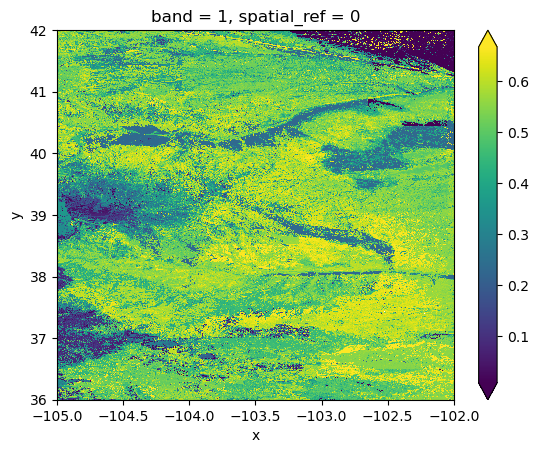

In [39]:
test.plot(robust=True)

In [ ]:
# Ideal soil ph of 4.8 to 8.0 (https://www.nrcs.usda.gov/plantmaterials/etpmcpg13196.pdf); mean of this range is 6.4
diff_soil_da = abs(6.4 - elev_clip_da)
test = (diff_soil_da - diff_soil_da.min()) / (diff_soil_da.max()-diff_soil_da.min())
soil_cutpt = (1.6 - diff_soil_da.min()) / (diff_soil_da.max() - diff_soil_da.min())

soil_cutpt

In [ ]:
test.plot(robust=True)

### Data Citations
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

Hegewisch, K.C. and Abatzoglou, J.T.. 'Data Download' web tool. Climate Toolbox (https://climatetoolbox.org/), version 2022-04-24.

In [ ]:
bounds = (select_grassland_gdf.total_bounds)

# Define extent and round to whole numbers for defining soil path file names
min_lon = math.floor(bounds[0])
max_lon = math.ceil(bounds[2])
min_lat = math.floor(bounds[1])
max_lat = math.ceil(bounds[3])

min_lon, max_lon,  min_lat, max_lat
# # https://stackoverflow.com/questions/68198525/geopandas-obtain-min-max-lat-and-long-for-all-geometries

# # Get boundaries
# select_grassland_bnd_gdf = select_grassland_gdf.bounds

# # Define extent and round to whole 
# min_lon = math.floor(float(select_grassland_bnd_gdf.minx.min()))
# max_lon = math.ceil(float(select_grassland_bnd_gdf.maxx.max()))
# min_lat = math.floor(float(select_grassland_bnd_gdf.miny.min()))
# max_lat = math.ceil(float(select_grassland_bnd_gdf.maxy.max()))

# min_lon, max_lon, max_lat, min_lat

In [ ]:
###########
# Old Polaris Download
###########
# Download Polaris tif files
# Code adapted from: 
        # https://www.tutorialspoint.com/downloading-files-from-web-using-python
        # https://github.com/njadid/Polaris_Processor/blob/master/download_polaris.py

# # # Set working directory to soil directory

# url_path_lst = []
def downloadPolaris(data_directory, geo_extent):
    """
    This function reads in Polaris soil data for a given extent into
    a specified data directory.

    Attributes
    ----------
    data_directory : path
        The path to the directory where the polaris data files are 
        to be stored.
    
    geo_extent: dictionary
        A dictionary specifying the min and maximum latitudes and 
        longitudes for the geographical extent to examine
    """
    
    bounds = (input_gdf.total_bounds)

      template_url = 'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/' \
                   '{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif'
      template_name = 'mean_ph_lat{0}{1}_lon{2}{3}.tif'
      lat_range = range(geo_extent['lat'][0],geo_extent['lat'][1])
      lon_range = range(geo_extent['lon'][0],geo_extent['lon'][1])
      for lat in lat_range:
        for lon in lon_range:
            url = template_url.format('ph',
                                      'mean',
                                      '60_100',
                                      str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            file_name = template_name.format(str(lat),
                                      str(lat+1),
                                      str(lon),
                                      str(lon+1))
            # url_path_lst.append(url)
            soil_dir = os.path.join(data_directory, "soil_data")
            file_name_path = os.path.join(soil_dir, file_name)
            if not os.path.exists(soil_dir):
                os.makedirs(soil_dir)
            if not os.path.exists(file_name_path): 
                print(file_name, "does not exist. Downloading file")
                r = requests.get(url, allow_redirects=True)
                open(file_name_path, 'wb').write(r.content)
            else:
                print(file_name, "is already downloaded")

# Define geographical extent
domain_extent = {}
domain_extent['lon'] = [min_lon, max_lon]
domain_extent['lat'] = [min_lat, max_lat]

downloadPolaris(data_dir, domain_extent)

# # Reset working directory
# os.chdir(data_dir)

In [ ]:
# https://www.geeksforgeeks.org/python-list-files-in-a-directory/
# Adapted from Multispectral Analysis assignment
def merge_soil_tif(soil_data_directory):
    # Merge soil tif data
    tif_paths = glob(os.path.join(data_dir, "soil_data", '*.tif'))
    das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
    merged_soil_da = rxrmerge.merge_arrays(das)
    # Save merged file to data directory
    merged_soil_da.rio.to_raster(os.path.join(data_dir, "merged_soil_da.tif"))

    test = rxr.open_rasterio(os.path.join(data_dir, "merged_soil_da.tif"), masked=True)

In [ ]:
# # Climate data
# clim_rcp45_url = (
#     "http://thredds.northwestknowledge.net:8080/thredds/catalog/"
#     "NWCSC_INTEGRATED_SCENARIOS_ALL_CLIMATE/macav2livneh/GFDL-ESM2M/"
#     "catalog.html?dataset=NWCSC_IS_ALL_SCAN/macav2livneh/GFDL-ESM2M/"
#     "macav2livneh_pr_GFDL-ESM2M_r1i1p1_rcp45_2026_2045_CONUS_monthly.nc"
# )

# r = requests.get(clim_rcp45_url, allow_redirects=True)
# open("clim_rcp45_2026_2045.nc", 'wb').write(r.content)


In [42]:
# Open the data from the thredds server
clim_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
                  "dodsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45"
                  "_2006_2099_CONUS_monthly.nc"
                 )
# ccsm_rcp45 = xr.open_dataset(ccsm_rcp45_url)
clim_rcp85 = xr.open_dataset(clim_rcp85_url)

# clim_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc")

# ccsm_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp45_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp85_url = ("http://thredds.northwestknowledge.net:8080/thredds/"
#                   "dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp85"
#                   "006_2099_CONUS_monthly.nc"
# )

# ccsm_rcp45 = xr.open_dataset(ccsm_rcp45_url)
ccsm_rcp85 = xr.open_dataset(ccsm_rcp45_url)

# clip_ccsm_rcp45_da = clim_rcp45.rio.clip_box(select_grassland_gdf.geometry)
clip_ccsm_rcp85_da = clim_rcp85.rio.clip_box(select_grassland_gdf.geometry)
#clim_rcp85.rio.clip_box(miny = -105, minx= 36, maxx=43, maxy=-102)
clip_clim_rcp85_da
# # Select the latitude, longitude, and timeframe to subset the data to

# # Ensure your latitude value is between 25 and 50, and your longitude value is between 235 and 292
# # latitude = 35
# # longitude = 270
# start_date = '2036-01'
# end_date = '2040-12'

# # Select a lat / lon location that you wish to use to extract the data
# latitude = clim_rcp45.lat.values[300]
# longitude = clim_rcp45.lon.values[150]
# print("You selected the following x,y location:", longitude, latitude)

# clim_rcp45.rio.clip_box(
#     minx=36,
#     miny=-105,
#     maxx=43,
#     maxy=-102,
# )

OSError: [Errno -90] NetCDF: file not found: 'http://thredds.northwestknowledge.net:8080/thredds/dsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp4006_2099_CONUS_monthly.nc'

In [44]:
# Import packages
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

# Models to chose from
model_name = ('bcc-csm1-1',
              'bcc-csm1-1-m',
              'BNU-ESM',
              'CanESM2',
              'CCSM4',
              'CNRM-CM5',
              'CSIRO-Mk3-6-0',
              'GFDL-ESM2G',
              'GFDL-ESM2M',
              'HadGEM2-CC365',
              'HadGEM2-ES365',
              'inmcm4',
              'IPSL-CM5A-MR',
              'IPSL-CM5A-LR',
              'IPSL-CM5B-LR',
              'MIROC5',
              'MIROC-ESM',
              'MIROC-ESM-CHEM',
              'MRI-CGCM3',
              'NorESM1-M')

# These are the variable options for the met data
variable_name = ('tasmax',
                 'tasmin',
                 'rhsmax',
                 'rhsmin',
                 'pr',
                 'rsds',
                 'uas',
                 'vas',
                 'huss')

# These are var options in long form
var_long_name = ('air_temperature',
                 'air_temperature',
                 'relative_humidity',
                 'relative_humidity',
                 'precipitation',
                 'surface_downwelling_shortwave_flux_in_air',
                 'eastward_wind',
                 'northward_wind',
                 'specific_humidity')

# This is the base url required to download data from the thredds server.
dir_path = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/'

# These are the variable options for the met data
variable_name = ('tasmax',
                 'tasmin',
                 'rhsmax',
                 'rhsmin',
                 'pr',
                 'rsds',
                 'uas',
                 'vas',
                 'huss')

# These are var options in long form
var_long_name = ('air_temperature',
                 'air_temperature',
                 'relative_humidity',
                 'relative_humidity',
                 'precipitation',
                 'surface_downwelling_shortwave_flux_in_air',
                 'eastward_wind',
                 'northward_wind',
                 'specific_humidity')

# Models to chose from
model_name = ('bcc-csm1-1',
              'bcc-csm1-1-m',
              'BNU-ESM',
              'CanESM2',
              'CCSM4',
              'CNRM-CM5',
              'CSIRO-Mk3-6-0',
              'GFDL-ESM2G',
              'GFDL-ESM2M',
              'HadGEM2-CC365',
              'HadGEM2-ES365',
              'inmcm4',
              'IPSL-CM5A-MR',
              'IPSL-CM5A-LR',
              'IPSL-CM5B-LR',
              'MIROC5',
              'MIROC-ESM',
              'MIROC-ESM-CHEM',
              'MRI-CGCM3',
              'NorESM1-M')

# Scenarios
scenario_type = ('historical', 'rcp45', 'rcp85')

# Year start and ends (historical vs projected)
year_start = ('1950', '2006', '2006')
year_end = ('2005', '2099', '2099')
run_num = [1] * 20
run_num[4] = 6  # setting CCSM4 with run 6
domain = 'CONUS'

# Model options between 0-19
model = 4
# Options 0-8 will work for var. Var maps to the variable name below
var = 4
# Options range from 0-2
scenario = 1

try: 
    print("Great! You have selected: \n \u2705 Variable: {} \n \u2705 Model: {}, "
      "\n \u2705 Scenario: {}".format(variable_name[var], 
                                      model_name[model],
                                      scenario_type[scenario]))
except IndexError as e:
    raise IndexError("Oops, it looks like you selected value that is "
                     "not within the range of values which is 0-2. please look"
                     "closely at your selected values.")
    
try:
    time = year_start[scenario]+'_' + year_end[scenario]
    print("\u2705 Your selected time period is:", time)
except IndexError as e:
    raise IndexError("Oops, it looks like you selected a scenario value that is \
                     not within the range of values which is 0-2")
    
# This code creates a path to the monthly MACA v2 data
file_name = ('agg_macav2metdata_' +
             str(variable_name[var]) +
             '_' +
             str(model_name[model]) +
             '_r' +
             str(run_num[model])+'i1p1_' +
             str(scenario_type[scenario]) +
             '_' +
             time + '_' +
             domain + '_monthly.nc')

print("\u2705 You are accessing:\n", file_name, "\n data in netcdf format")

full_file_path = dir_path + file_name
print("The full path to your data is: \n", full_file_path)

# Open the data from the thredds server
try:
    max_temp_xr = xr.open_dataset(full_file_path)
except OSError as oe:
    print("Oops, it looks like the file that you are trying to connect to, "
          "{}, doesn't exist. Try to revisit your model options to ensure "
          "the data exist on the server.  ".format(full_file_path))
    
max_temp_xr

Great! You have selected: 
 ✅ Variable: pr 
 ✅ Model: CCSM4, 
 ✅ Scenario: rcp45
✅ Your selected time period is: 2006_2099
✅ You are accessing:
 agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc 
 data in netcdf format
The full path to your data is: 
 http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc


<xarray.Dataset>
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 1128)
Coordinates:
  * lat            (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 1
  * lon            (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time           (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [48]:

# Define urls for Climate Data
CCSM4_rcp45_pr_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)
MIROC5_rcp45_pr_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_MIROC5_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)

try:
    CCSM4_rcp45_pr_da = xr.open_dataset(CCSM4_rcp45_pr_url)
    MIROC5_rcp45_pr_da = xr.open_dataset(MIROC5_rcp45_pr_url)
except OSError as oe:
    print("Oops, it looks like the file that you are trying to connect to, "
          "{}, doesn't exist. Try to revisit your model options to ensure "
          "the data exist on the server.  ".format(full_file_path))
    
MIROC5_rcp45_pr_da

<xarray.Dataset>
Dimensions:        (lat: 585, crs: 1, lon: 1386, time: 1128)
Coordinates:
  * lat            (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs            (crs) int32 1
  * lon            (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time           (time) object 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
Data variables:
    precipitation  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [54]:
MIROC5_rcp45_pr_clip_da = MIROC5_rcp45_pr_da.rio.clip_box(

NoDataInBounds: No data found in bounds. Data variable: precipitation

In [ ]:
url = ("http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_"
       "macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly."
       "nc?var=precipitation"
       "&disableLLSubset=on"
       "&disableProjSubset=on"
       "&horizStride=1"
       "&time_start=2050-01-15T00%3A00%3A00Z"
       "&time_end=2050-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"
)

response = requests.get(url)

In [ ]:
CCSM4_rcp45_2050_path = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")
with open(CCSM4_rcp45_2050_path, 'wb') as climate_file:
    climate_file.write(response.content)

In [ ]:
import rasterio

climate_data = rasterio.open(CCSM4_rcp45_2050_path)

climate_data.subdatasets

In [ ]:
%%bash
gdalinfo ~/earth-analytics/data/final/pr_CCSM4_rcp45_2050.nc

In [ ]:
file_name = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")

if not os.path.exists(os.path.join(data_dir, file_name)): 
    open(file_name, 'wb').write(response.content)

CCSM4_rcp45_2050_path = os.path.join(data_dir, "pr_CCSM4_rcp45_2050.nc")
with open(CCSM4_rcp45_2050_path, 'wb') as climate_file:
    climate_file.write(response.content)

In [ ]:
rxr.open_rasterio(CCSM4_rcp45_2050_path, masked=True)

In [ ]:
# Define urls for Climate Data
url = ("http://thredds.northwestknowledge.net:8080/thredds/dodsC/"
    "agg_macav2metdata_pr_CCSM4_r6i1p1_rcp45_2006_2099_CONUS_monthly.nc"
)
test = rxr.open_rasterio(url)

### Data Citations
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

Hegewisch, K.C. and Abatzoglou, J.T.. 'Data Download' web tool. Climate Toolbox (https://climatetoolbox.org/), version 2022-04-24.
